In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision

In [0]:
%matplotlib inline

In [0]:
batch_size = 128
img_size = 32
channels = 3
nz = 100 #latent rep size
lr = 0.0002
beta1 = 0.5


In [5]:
a=np.arange(10)
np.random.permutation(a)

array([5, 8, 9, 0, 6, 2, 7, 1, 3, 4])

Extracting ./data/cifar-10-python.tar.gz to ./data


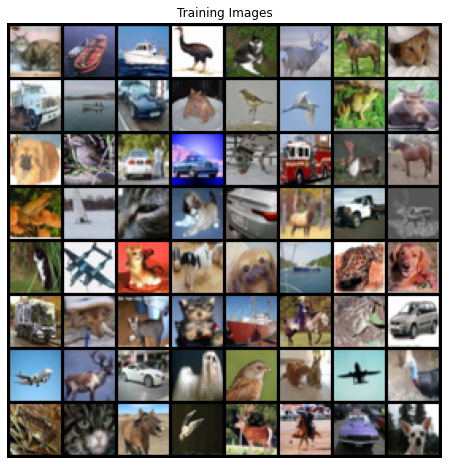

In [6]:
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform,)
a=np.arange(trainset.data.shape[0])
a=np.random.permutation(a)
b=45000

train_ds = Subset(trainset, a[:b])
val_ds = Subset(trainset, a[b:])
#trainset = torchvision.datasets.CIFAR10(root='./data', =True,
#                                        download=True)
batch_size2=2000
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

valloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size2,
                                         shuffle=True, num_workers=4)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

import torchvision.utils as vutils
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, img_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(img_size * 8),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 256*4*4
            nn.ConvTranspose2d(img_size * 8, img_size* 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 4),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 128*8*8
            nn.ConvTranspose2d( img_size * 4, img_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size * 2),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            # out- 64*16*16
            nn.ConvTranspose2d( img_size * 2, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # out- 3*32*32
        )
        
    def forward(self, input):
        return self.main(input)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3*32*32 
            nn.Conv2d(3, img_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_size, 2*img_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(img_size*2, img_size*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_size*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(img_size*2, 1, 4, 1, 0, bias=False),
            #nn.Flatten(-1,10)
            nn.Sigmoid()
            )
    def forward(self, input):
        return self.main(input)

In [9]:
model

NameError: ignored

In [12]:
# Create the generator
netG = Generator().to(device)

netG.apply(weights_init)

print(netG)

# Create the Discriminator
netD = Discriminator().to(device)

netD.apply(weights_init)

print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1, inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1, inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(ne

In [0]:
import os
import pathlib
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter

import numpy as np
import torch
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

try:
    from tqdm import tqdm
except ImportError:
    # If not tqdm is not available, provide a mock version of it
    def tqdm(x): return x

from inception import InceptionV3

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument('path', type=str, nargs=2,
                    help=('Path to the generated images or '
                          'to .npz statistic files'))
parser.add_argument('--batch-size', type=int, default=50,
                    help='Batch size to use')
parser.add_argument('--dims', type=int, default=2048,
                    choices=list(InceptionV3.BLOCK_INDEX_BY_DIM),
                    help=('Dimensionality of Inception features to use. '
                          'By default, uses pool3 features'))
parser.add_argument('-c', '--gpu', default='', type=str,
                    help='GPU to use (leave blank for CPU only)')


def imread(filename):
    """
    Loads an image file into a (height, width, 3) uint8 ndarray.
    """
    return np.asarray(Image.open(filename), dtype=np.uint8)[..., :3]


def get_activations(files, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    pred_arr = np.empty((len(files), dims))

    for i in tqdm(range(0, len(files), batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')

    return pred_arr


def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)


def calculate_activation_statistics(files, model, batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the inception model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def _compute_statistics_of_path(path, model, batch_size, dims, cuda):
    if path.endswith('.npz'):
        f = np.load(path)
        m, s = f['mu'][:], f['sigma'][:]
        f.close()
    else:
        path = pathlib.Path(path)
        files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
        m, s = calculate_activation_statistics(files, model, batch_size,
                                               dims, cuda)

    return m, s


def calculate_fid_given_paths(paths, batch_size, cuda, dims):
    """Calculates the FID of two paths"""
    for p in paths:
        if not os.path.exists(p):
            raise RuntimeError('Invalid path: %s' % p)

    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = _compute_statistics_of_path(paths[0], model, batch_size,
                                         dims, cuda)
    m2, s2 = _compute_statistics_of_path(paths[1], model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value

    
    
def act_stats(data1,data2,batch_size=50,
                                    dims=2048, cuda=False, verbose=False):
    
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()

    m1, s1 = compute_stats(data1, model, batch_size,
                                         dims, cuda)
    m2, s2 = compute_stats(data2, model, batch_size,
                                         dims, cuda)
    fid_value = calculate_frechet_distance(m1, s1, m2, s2)

    return fid_value
    
def compute_stats(data, model, batch_size=50, dims=2048,
                    cuda=False, verbose=False):
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)
        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

def compute_mean_cov(data,batch_size=50,
                                    dims=2048, cuda=True, verbose=False):
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

    model = InceptionV3([block_idx])
    if cuda:
        model.cuda()
    model.eval()

    if batch_size > data.shape[0]:
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(data.shape[0])

    pred_arr = np.empty((data.shape[0], dims))

    for i in tqdm(range(0, data.shape[0], batch_size)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i
        end = i + batch_size
        
        images=data[start:end,:,:,:].astype(np.float32)

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
        if pred.size(2) != 1 or pred.size(3) != 1:
            pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

        pred_arr[start:end] = pred.cpu().data.numpy().reshape(pred.size(0), -1)

    if verbose:
        print(' done')
    
    
    mu = np.mean(pred_arr, axis=0)
    sigma = np.cov(pred_arr, rowvar=False)
    return mu, sigma

In [14]:
import torch.optim as optim
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

data1=iter(valloader).next()[0].numpy()
mu1,cov1=compute_mean_cov(data1/2+0.5)
best_fid=999

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 40/40 [00:04<00:00,  8.17it/s]


In [15]:
# Training Loop
num_epochs = 50
img_list = []
G_losses = []
D_losses = []
fid_scores=[]
iters = 0

for epoch in range(num_epochs):

    for i, data in enumerate(dataloader, 0):
        
        netD.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        output = netD(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        #Generator
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
    with torch.no_grad():
        data2=netG(torch.randn(1000, nz, 1, 1, device=device))
    data2=data2.cpu().numpy()
    mu2,cov2=compute_mean_cov(data2/2+0.5)
    fid=calculate_frechet_distance(mu1,cov1,mu2,cov2)
    fid_scores.append(fid)
    print('fid score :',fid)
    if (fid<best_fid):
        best_fid=fid
        torch.save(netD.state_dict(), 'netD.pt')
        torch.save(netG.state_dict(), 'netG.pt')

/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/50][0/352]	Loss_D: 1.2858	Loss_G: 1.0066	D(x): 0.5417	D(G(z)): 0.4694 / 0.3754
[0/50][50/352]	Loss_D: 1.0180	Loss_G: 1.6846	D(x): 0.6057	D(G(z)): 0.3766 / 0.1894
[0/50][100/352]	Loss_D: 0.5739	Loss_G: 2.4887	D(x): 0.7552	D(G(z)): 0.2407 / 0.0895
[0/50][150/352]	Loss_D: 0.9317	Loss_G: 1.7497	D(x): 0.6317	D(G(z)): 0.3274 / 0.1835
[0/50][200/352]	Loss_D: 1.1784	Loss_G: 1.3192	D(x): 0.5547	D(G(z)): 0.4116 / 0.2762
[0/50][250/352]	Loss_D: 1.0479	Loss_G: 1.5619	D(x): 0.6008	D(G(z)): 0.3912 / 0.2210
[0/50][300/352]	Loss_D: 0.6391	Loss_G: 2.2577	D(x): 0.6950	D(G(z)): 0.2252 / 0.1114
[0/50][350/352]	Loss_D: 1.3432	Loss_G: 1.3479	D(x): 0.5507	D(G(z)): 0.4865 / 0.2889


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 270.65250030473493
[1/50][0/352]	Loss_D: 1.4050	Loss_G: 1.0813	D(x): 0.4944	D(G(z)): 0.4612 / 0.3635
[1/50][50/352]	Loss_D: 1.2254	Loss_G: 1.2586	D(x): 0.5321	D(G(z)): 0.4103 / 0.3016
[1/50][100/352]	Loss_D: 1.0245	Loss_G: 1.6612	D(x): 0.5995	D(G(z)): 0.3695 / 0.1984
[1/50][150/352]	Loss_D: 1.1699	Loss_G: 1.3655	D(x): 0.5596	D(G(z)): 0.4119 / 0.2703
[1/50][200/352]	Loss_D: 1.0034	Loss_G: 1.9284	D(x): 0.5677	D(G(z)): 0.3060 / 0.1581
[1/50][250/352]	Loss_D: 1.0744	Loss_G: 1.5906	D(x): 0.5808	D(G(z)): 0.3543 / 0.2239
[1/50][300/352]	Loss_D: 0.8886	Loss_G: 1.4701	D(x): 0.6541	D(G(z)): 0.3396 / 0.2455
[1/50][350/352]	Loss_D: 0.5973	Loss_G: 2.1871	D(x): 0.7647	D(G(z)): 0.2653 / 0.1277


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 245.19068543334595
[2/50][0/352]	Loss_D: 0.7405	Loss_G: 2.1799	D(x): 0.7113	D(G(z)): 0.3004 / 0.1292
[2/50][50/352]	Loss_D: 0.6029	Loss_G: 2.2437	D(x): 0.7288	D(G(z)): 0.2258 / 0.1236
[2/50][100/352]	Loss_D: 0.6753	Loss_G: 1.9799	D(x): 0.7204	D(G(z)): 0.2550 / 0.1662
[2/50][150/352]	Loss_D: 0.7391	Loss_G: 1.6633	D(x): 0.6301	D(G(z)): 0.1967 / 0.2103
[2/50][200/352]	Loss_D: 1.0023	Loss_G: 1.2499	D(x): 0.5551	D(G(z)): 0.2887 / 0.3242
[2/50][250/352]	Loss_D: 1.1799	Loss_G: 1.6209	D(x): 0.5357	D(G(z)): 0.3600 / 0.2253
[2/50][300/352]	Loss_D: 1.1881	Loss_G: 1.6028	D(x): 0.5572	D(G(z)): 0.3683 / 0.2226
[2/50][350/352]	Loss_D: 0.7130	Loss_G: 1.8434	D(x): 0.6944	D(G(z)): 0.2651 / 0.1818


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 241.9207730031406
[3/50][0/352]	Loss_D: 0.8656	Loss_G: 1.6462	D(x): 0.5893	D(G(z)): 0.2356 / 0.2172
[3/50][50/352]	Loss_D: 1.0817	Loss_G: 1.2992	D(x): 0.4903	D(G(z)): 0.2377 / 0.3094
[3/50][100/352]	Loss_D: 0.9009	Loss_G: 1.9098	D(x): 0.7217	D(G(z)): 0.3947 / 0.1765
[3/50][150/352]	Loss_D: 0.8873	Loss_G: 1.8993	D(x): 0.6193	D(G(z)): 0.2703 / 0.1770
[3/50][200/352]	Loss_D: 0.8555	Loss_G: 1.7581	D(x): 0.6478	D(G(z)): 0.2820 / 0.2000
[3/50][250/352]	Loss_D: 0.9518	Loss_G: 1.7934	D(x): 0.6578	D(G(z)): 0.3530 / 0.2020
[3/50][300/352]	Loss_D: 1.1034	Loss_G: 1.4168	D(x): 0.4493	D(G(z)): 0.1894 / 0.2805
[3/50][350/352]	Loss_D: 0.7654	Loss_G: 1.7685	D(x): 0.7232	D(G(z)): 0.3220 / 0.1968


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 176.64674844457073
[4/50][0/352]	Loss_D: 0.7448	Loss_G: 1.6356	D(x): 0.7178	D(G(z)): 0.3019 / 0.2262
[4/50][50/352]	Loss_D: 1.0319	Loss_G: 1.2976	D(x): 0.5007	D(G(z)): 0.2164 / 0.3085
[4/50][100/352]	Loss_D: 0.8495	Loss_G: 1.4871	D(x): 0.6046	D(G(z)): 0.2501 / 0.2627
[4/50][150/352]	Loss_D: 0.9501	Loss_G: 1.5655	D(x): 0.7104	D(G(z)): 0.4201 / 0.2379
[4/50][200/352]	Loss_D: 1.0128	Loss_G: 1.1134	D(x): 0.5961	D(G(z)): 0.3480 / 0.3533
[4/50][250/352]	Loss_D: 0.7691	Loss_G: 1.6562	D(x): 0.7591	D(G(z)): 0.3626 / 0.2117
[4/50][300/352]	Loss_D: 0.6419	Loss_G: 2.1458	D(x): 0.7750	D(G(z)): 0.2945 / 0.1409
[4/50][350/352]	Loss_D: 0.8311	Loss_G: 1.4280	D(x): 0.6453	D(G(z)): 0.2808 / 0.2716


100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


fid score : 171.13519667235468
[5/50][0/352]	Loss_D: 0.9028	Loss_G: 1.4360	D(x): 0.5868	D(G(z)): 0.2373 / 0.2837
[5/50][50/352]	Loss_D: 1.7063	Loss_G: 1.7782	D(x): 0.2373	D(G(z)): 0.0529 / 0.1989
[5/50][100/352]	Loss_D: 0.8739	Loss_G: 1.5629	D(x): 0.6817	D(G(z)): 0.3437 / 0.2469
[5/50][150/352]	Loss_D: 0.9934	Loss_G: 1.2305	D(x): 0.6749	D(G(z)): 0.4067 / 0.3225
[5/50][200/352]	Loss_D: 1.0418	Loss_G: 1.3804	D(x): 0.6457	D(G(z)): 0.4150 / 0.2780
[5/50][250/352]	Loss_D: 1.0466	Loss_G: 1.9155	D(x): 0.7109	D(G(z)): 0.4611 / 0.1758
[5/50][300/352]	Loss_D: 1.0835	Loss_G: 1.4967	D(x): 0.6509	D(G(z)): 0.4367 / 0.2508
[5/50][350/352]	Loss_D: 1.0588	Loss_G: 1.1352	D(x): 0.5517	D(G(z)): 0.3095 / 0.3577


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 168.68626330908072
[6/50][0/352]	Loss_D: 1.0836	Loss_G: 1.7780	D(x): 0.7534	D(G(z)): 0.5091 / 0.1977
[6/50][50/352]	Loss_D: 0.9752	Loss_G: 1.4889	D(x): 0.6507	D(G(z)): 0.3786 / 0.2511
[6/50][100/352]	Loss_D: 0.8513	Loss_G: 1.5403	D(x): 0.7103	D(G(z)): 0.3649 / 0.2398
[6/50][150/352]	Loss_D: 0.9864	Loss_G: 1.1591	D(x): 0.6294	D(G(z)): 0.3727 / 0.3355
[6/50][200/352]	Loss_D: 0.9390	Loss_G: 0.9794	D(x): 0.5931	D(G(z)): 0.3003 / 0.4014
[6/50][250/352]	Loss_D: 0.8953	Loss_G: 1.3211	D(x): 0.6010	D(G(z)): 0.2739 / 0.2924
[6/50][300/352]	Loss_D: 1.0540	Loss_G: 1.0965	D(x): 0.5945	D(G(z)): 0.3626 / 0.3688
[6/50][350/352]	Loss_D: 1.0417	Loss_G: 1.3499	D(x): 0.6734	D(G(z)): 0.4419 / 0.2864


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 145.58353227201138
[7/50][0/352]	Loss_D: 0.9463	Loss_G: 1.2939	D(x): 0.6492	D(G(z)): 0.3639 / 0.3061
[7/50][50/352]	Loss_D: 1.0983	Loss_G: 1.0210	D(x): 0.5779	D(G(z)): 0.3716 / 0.3846
[7/50][100/352]	Loss_D: 0.8413	Loss_G: 1.3161	D(x): 0.6997	D(G(z)): 0.3533 / 0.2949
[7/50][150/352]	Loss_D: 1.0743	Loss_G: 1.2884	D(x): 0.5126	D(G(z)): 0.2886 / 0.2996
[7/50][200/352]	Loss_D: 0.9642	Loss_G: 1.7858	D(x): 0.6955	D(G(z)): 0.3978 / 0.2042
[7/50][250/352]	Loss_D: 0.8783	Loss_G: 1.5852	D(x): 0.6456	D(G(z)): 0.3194 / 0.2294
[7/50][300/352]	Loss_D: 1.0364	Loss_G: 1.7085	D(x): 0.7512	D(G(z)): 0.4878 / 0.2107
[7/50][350/352]	Loss_D: 0.9757	Loss_G: 1.1592	D(x): 0.5931	D(G(z)): 0.3183 / 0.3465


100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


fid score : 136.34803845327542
[8/50][0/352]	Loss_D: 1.0406	Loss_G: 1.2413	D(x): 0.5223	D(G(z)): 0.2682 / 0.3192
[8/50][50/352]	Loss_D: 1.0303	Loss_G: 1.4379	D(x): 0.6525	D(G(z)): 0.4068 / 0.2750
[8/50][100/352]	Loss_D: 0.9351	Loss_G: 1.3524	D(x): 0.6138	D(G(z)): 0.3221 / 0.2834
[8/50][150/352]	Loss_D: 1.0418	Loss_G: 1.5173	D(x): 0.6822	D(G(z)): 0.4371 / 0.2498
[8/50][200/352]	Loss_D: 1.0830	Loss_G: 1.3455	D(x): 0.6411	D(G(z)): 0.4289 / 0.2931
[8/50][250/352]	Loss_D: 1.0762	Loss_G: 1.4467	D(x): 0.6664	D(G(z)): 0.4550 / 0.2657
[8/50][300/352]	Loss_D: 1.0917	Loss_G: 1.3894	D(x): 0.5845	D(G(z)): 0.3823 / 0.2778
[8/50][350/352]	Loss_D: 1.1160	Loss_G: 1.6405	D(x): 0.6322	D(G(z)): 0.4318 / 0.2252


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 126.31410666198809
[9/50][0/352]	Loss_D: 0.9618	Loss_G: 1.9478	D(x): 0.6755	D(G(z)): 0.3935 / 0.1687
[9/50][50/352]	Loss_D: 0.9543	Loss_G: 1.5261	D(x): 0.6625	D(G(z)): 0.3869 / 0.2423
[9/50][100/352]	Loss_D: 0.9679	Loss_G: 1.4757	D(x): 0.6108	D(G(z)): 0.3331 / 0.2561
[9/50][150/352]	Loss_D: 1.1138	Loss_G: 1.2120	D(x): 0.5245	D(G(z)): 0.3188 / 0.3269
[9/50][200/352]	Loss_D: 1.0177	Loss_G: 1.2018	D(x): 0.5494	D(G(z)): 0.2970 / 0.3392
[9/50][250/352]	Loss_D: 1.0559	Loss_G: 1.4022	D(x): 0.6233	D(G(z)): 0.4013 / 0.2724
[9/50][300/352]	Loss_D: 0.8627	Loss_G: 1.8009	D(x): 0.6863	D(G(z)): 0.3510 / 0.1884
[9/50][350/352]	Loss_D: 1.2104	Loss_G: 1.4162	D(x): 0.6214	D(G(z)): 0.4855 / 0.2635


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 122.54033561874888
[10/50][0/352]	Loss_D: 1.0930	Loss_G: 0.8648	D(x): 0.5316	D(G(z)): 0.3269 / 0.4465
[10/50][50/352]	Loss_D: 1.1176	Loss_G: 1.0401	D(x): 0.4889	D(G(z)): 0.2829 / 0.3825
[10/50][100/352]	Loss_D: 1.0172	Loss_G: 1.2000	D(x): 0.5664	D(G(z)): 0.3189 / 0.3303
[10/50][150/352]	Loss_D: 1.0557	Loss_G: 1.7977	D(x): 0.7622	D(G(z)): 0.5118 / 0.1917
[10/50][200/352]	Loss_D: 0.9841	Loss_G: 1.0822	D(x): 0.6074	D(G(z)): 0.3504 / 0.3632
[10/50][250/352]	Loss_D: 1.0587	Loss_G: 1.3457	D(x): 0.6906	D(G(z)): 0.4646 / 0.2890
[10/50][300/352]	Loss_D: 1.0034	Loss_G: 1.6251	D(x): 0.7302	D(G(z)): 0.4728 / 0.2157
[10/50][350/352]	Loss_D: 0.9878	Loss_G: 1.4919	D(x): 0.6175	D(G(z)): 0.3561 / 0.2508


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 119.08351091475112
[11/50][0/352]	Loss_D: 0.8665	Loss_G: 1.8237	D(x): 0.7709	D(G(z)): 0.4270 / 0.1792
[11/50][50/352]	Loss_D: 1.1796	Loss_G: 2.1414	D(x): 0.7893	D(G(z)): 0.5796 / 0.1347
[11/50][100/352]	Loss_D: 1.1283	Loss_G: 1.3566	D(x): 0.5757	D(G(z)): 0.3924 / 0.2867
[11/50][150/352]	Loss_D: 0.9536	Loss_G: 1.3646	D(x): 0.5936	D(G(z)): 0.3170 / 0.2766
[11/50][200/352]	Loss_D: 0.9660	Loss_G: 1.3679	D(x): 0.5775	D(G(z)): 0.2983 / 0.2924
[11/50][250/352]	Loss_D: 1.0374	Loss_G: 1.2720	D(x): 0.5755	D(G(z)): 0.3485 / 0.3034
[11/50][300/352]	Loss_D: 0.9710	Loss_G: 1.2944	D(x): 0.6439	D(G(z)): 0.3837 / 0.2937
[11/50][350/352]	Loss_D: 1.1188	Loss_G: 1.8084	D(x): 0.7215	D(G(z)): 0.5159 / 0.1817


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 110.25564444270367
[12/50][0/352]	Loss_D: 1.1274	Loss_G: 0.8708	D(x): 0.5063	D(G(z)): 0.3171 / 0.4404
[12/50][50/352]	Loss_D: 0.8889	Loss_G: 0.8450	D(x): 0.5645	D(G(z)): 0.2410 / 0.4539
[12/50][100/352]	Loss_D: 1.0320	Loss_G: 1.1619	D(x): 0.6062	D(G(z)): 0.3814 / 0.3392
[12/50][150/352]	Loss_D: 1.2084	Loss_G: 1.4719	D(x): 0.6187	D(G(z)): 0.4837 / 0.2509
[12/50][200/352]	Loss_D: 0.8845	Loss_G: 1.3948	D(x): 0.6594	D(G(z)): 0.3472 / 0.2697
[12/50][250/352]	Loss_D: 1.1866	Loss_G: 2.5039	D(x): 0.7645	D(G(z)): 0.5750 / 0.0961
[12/50][300/352]	Loss_D: 1.3403	Loss_G: 0.9757	D(x): 0.3589	D(G(z)): 0.2073 / 0.4068
[12/50][350/352]	Loss_D: 0.9942	Loss_G: 1.5202	D(x): 0.5739	D(G(z)): 0.3232 / 0.2395


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


fid score : 114.65491050716082
[13/50][0/352]	Loss_D: 1.1115	Loss_G: 1.2554	D(x): 0.6015	D(G(z)): 0.4152 / 0.3088
[13/50][50/352]	Loss_D: 1.5111	Loss_G: 0.6290	D(x): 0.2986	D(G(z)): 0.1708 / 0.5594
[13/50][100/352]	Loss_D: 1.0860	Loss_G: 1.3197	D(x): 0.5525	D(G(z)): 0.3438 / 0.2932
[13/50][150/352]	Loss_D: 1.1346	Loss_G: 1.3639	D(x): 0.6391	D(G(z)): 0.4563 / 0.2829
[13/50][200/352]	Loss_D: 1.1634	Loss_G: 1.1171	D(x): 0.4489	D(G(z)): 0.2529 / 0.3542
[13/50][250/352]	Loss_D: 1.2563	Loss_G: 0.6772	D(x): 0.4804	D(G(z)): 0.3603 / 0.5326
[13/50][300/352]	Loss_D: 0.9625	Loss_G: 1.4956	D(x): 0.6751	D(G(z)): 0.4015 / 0.2529
[13/50][350/352]	Loss_D: 0.8860	Loss_G: 1.4693	D(x): 0.6908	D(G(z)): 0.3746 / 0.2592


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 106.25547199897363
[14/50][0/352]	Loss_D: 1.0779	Loss_G: 1.3481	D(x): 0.6290	D(G(z)): 0.4190 / 0.2861
[14/50][50/352]	Loss_D: 1.2087	Loss_G: 1.6228	D(x): 0.7256	D(G(z)): 0.5529 / 0.2239
[14/50][100/352]	Loss_D: 1.0376	Loss_G: 1.2867	D(x): 0.6914	D(G(z)): 0.4553 / 0.3003
[14/50][150/352]	Loss_D: 1.1451	Loss_G: 1.3531	D(x): 0.6601	D(G(z)): 0.4884 / 0.2845
[14/50][200/352]	Loss_D: 1.3589	Loss_G: 2.0911	D(x): 0.7480	D(G(z)): 0.6263 / 0.1447
[14/50][250/352]	Loss_D: 1.0725	Loss_G: 1.4256	D(x): 0.6514	D(G(z)): 0.4382 / 0.2647
[14/50][300/352]	Loss_D: 1.0499	Loss_G: 1.2983	D(x): 0.5721	D(G(z)): 0.3498 / 0.3037
[14/50][350/352]	Loss_D: 1.1326	Loss_G: 1.0521	D(x): 0.5441	D(G(z)): 0.3580 / 0.3761


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 102.28819546589318
[15/50][0/352]	Loss_D: 1.1664	Loss_G: 1.0345	D(x): 0.4953	D(G(z)): 0.3220 / 0.3790
[15/50][50/352]	Loss_D: 1.0706	Loss_G: 1.1182	D(x): 0.6208	D(G(z)): 0.4141 / 0.3486
[15/50][100/352]	Loss_D: 1.1115	Loss_G: 1.9218	D(x): 0.7659	D(G(z)): 0.5402 / 0.1680
[15/50][150/352]	Loss_D: 1.1433	Loss_G: 1.1760	D(x): 0.5757	D(G(z)): 0.4031 / 0.3324
[15/50][200/352]	Loss_D: 1.1342	Loss_G: 1.0280	D(x): 0.5245	D(G(z)): 0.3424 / 0.3789
[15/50][250/352]	Loss_D: 1.1908	Loss_G: 1.6061	D(x): 0.6181	D(G(z)): 0.4731 / 0.2202
[15/50][300/352]	Loss_D: 0.9492	Loss_G: 1.3575	D(x): 0.5545	D(G(z)): 0.2648 / 0.2795
[15/50][350/352]	Loss_D: 1.0660	Loss_G: 1.6189	D(x): 0.7036	D(G(z)): 0.4791 / 0.2244


100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


fid score : 97.71061550976526
[16/50][0/352]	Loss_D: 1.1393	Loss_G: 1.4637	D(x): 0.7084	D(G(z)): 0.5162 / 0.2594
[16/50][50/352]	Loss_D: 1.0533	Loss_G: 1.2592	D(x): 0.6101	D(G(z)): 0.3883 / 0.3069
[16/50][100/352]	Loss_D: 1.1131	Loss_G: 1.2175	D(x): 0.5841	D(G(z)): 0.3940 / 0.3200
[16/50][150/352]	Loss_D: 1.0142	Loss_G: 1.1344	D(x): 0.5909	D(G(z)): 0.3533 / 0.3424
[16/50][200/352]	Loss_D: 0.8694	Loss_G: 1.3570	D(x): 0.6586	D(G(z)): 0.3407 / 0.2750
[16/50][250/352]	Loss_D: 1.0100	Loss_G: 1.3599	D(x): 0.6381	D(G(z)): 0.4011 / 0.2734
[16/50][300/352]	Loss_D: 0.9865	Loss_G: 1.0619	D(x): 0.6008	D(G(z)): 0.3488 / 0.3645
[16/50][350/352]	Loss_D: 0.9441	Loss_G: 1.2004	D(x): 0.5993	D(G(z)): 0.3211 / 0.3230


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 97.85938463386657
[17/50][0/352]	Loss_D: 0.8056	Loss_G: 1.6291	D(x): 0.6507	D(G(z)): 0.2884 / 0.2195
[17/50][50/352]	Loss_D: 1.1406	Loss_G: 2.0037	D(x): 0.7779	D(G(z)): 0.5622 / 0.1546
[17/50][100/352]	Loss_D: 1.0960	Loss_G: 1.3202	D(x): 0.6592	D(G(z)): 0.4503 / 0.2926
[17/50][150/352]	Loss_D: 1.0636	Loss_G: 1.0995	D(x): 0.5996	D(G(z)): 0.3812 / 0.3660
[17/50][200/352]	Loss_D: 1.0836	Loss_G: 1.1193	D(x): 0.4940	D(G(z)): 0.2763 / 0.3484
[17/50][250/352]	Loss_D: 1.0253	Loss_G: 1.4372	D(x): 0.5137	D(G(z)): 0.2536 / 0.2646
[17/50][300/352]	Loss_D: 0.9968	Loss_G: 1.0940	D(x): 0.5552	D(G(z)): 0.2964 / 0.3570
[17/50][350/352]	Loss_D: 1.1885	Loss_G: 1.8283	D(x): 0.6632	D(G(z)): 0.4988 / 0.1851


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 101.36274042657362
[18/50][0/352]	Loss_D: 1.0523	Loss_G: 1.4466	D(x): 0.7446	D(G(z)): 0.5055 / 0.2628
[18/50][50/352]	Loss_D: 1.0868	Loss_G: 1.2125	D(x): 0.6760	D(G(z)): 0.4770 / 0.3184
[18/50][100/352]	Loss_D: 0.9156	Loss_G: 1.6289	D(x): 0.6988	D(G(z)): 0.4015 / 0.2195
[18/50][150/352]	Loss_D: 1.2435	Loss_G: 1.3058	D(x): 0.5748	D(G(z)): 0.4639 / 0.2901
[18/50][200/352]	Loss_D: 1.1959	Loss_G: 0.8355	D(x): 0.4576	D(G(z)): 0.2715 / 0.4526
[18/50][250/352]	Loss_D: 0.7298	Loss_G: 1.6530	D(x): 0.7693	D(G(z)): 0.3548 / 0.2153
[18/50][300/352]	Loss_D: 1.0503	Loss_G: 1.2784	D(x): 0.6078	D(G(z)): 0.3845 / 0.3040
[18/50][350/352]	Loss_D: 0.9788	Loss_G: 0.7470	D(x): 0.4819	D(G(z)): 0.1793 / 0.4961


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 96.37167018479124
[19/50][0/352]	Loss_D: 1.0425	Loss_G: 0.3970	D(x): 0.4579	D(G(z)): 0.1880 / 0.6873
[19/50][50/352]	Loss_D: 1.1276	Loss_G: 1.0394	D(x): 0.5126	D(G(z)): 0.3263 / 0.3808
[19/50][100/352]	Loss_D: 0.8230	Loss_G: 1.4837	D(x): 0.6639	D(G(z)): 0.3140 / 0.2520
[19/50][150/352]	Loss_D: 1.0268	Loss_G: 1.2412	D(x): 0.5524	D(G(z)): 0.3100 / 0.3105
[19/50][200/352]	Loss_D: 1.2361	Loss_G: 1.0436	D(x): 0.5882	D(G(z)): 0.4645 / 0.3798
[19/50][250/352]	Loss_D: 0.9691	Loss_G: 1.5089	D(x): 0.7032	D(G(z)): 0.4272 / 0.2479
[19/50][300/352]	Loss_D: 0.9716	Loss_G: 1.5115	D(x): 0.5652	D(G(z)): 0.2928 / 0.2485
[19/50][350/352]	Loss_D: 0.8881	Loss_G: 1.2312	D(x): 0.6411	D(G(z)): 0.3283 / 0.3169


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 95.39228908810549
[20/50][0/352]	Loss_D: 1.0700	Loss_G: 0.9618	D(x): 0.5365	D(G(z)): 0.3170 / 0.4033
[20/50][50/352]	Loss_D: 1.0245	Loss_G: 1.2629	D(x): 0.5886	D(G(z)): 0.3448 / 0.3064
[20/50][100/352]	Loss_D: 0.9221	Loss_G: 1.4898	D(x): 0.6741	D(G(z)): 0.3844 / 0.2519
[20/50][150/352]	Loss_D: 0.9836	Loss_G: 1.3313	D(x): 0.6561	D(G(z)): 0.4067 / 0.2801
[20/50][200/352]	Loss_D: 0.8883	Loss_G: 1.3059	D(x): 0.6403	D(G(z)): 0.3310 / 0.2893
[20/50][250/352]	Loss_D: 1.3133	Loss_G: 1.8056	D(x): 0.7706	D(G(z)): 0.6150 / 0.1882
[20/50][300/352]	Loss_D: 1.1061	Loss_G: 1.9389	D(x): 0.7891	D(G(z)): 0.5446 / 0.1624
[20/50][350/352]	Loss_D: 1.0425	Loss_G: 1.2076	D(x): 0.5588	D(G(z)): 0.3315 / 0.3247


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 91.91778797027996
[21/50][0/352]	Loss_D: 1.0670	Loss_G: 1.2270	D(x): 0.6913	D(G(z)): 0.4753 / 0.3158
[21/50][50/352]	Loss_D: 1.0154	Loss_G: 1.0916	D(x): 0.5716	D(G(z)): 0.3289 / 0.3612
[21/50][100/352]	Loss_D: 0.9770	Loss_G: 1.4486	D(x): 0.6877	D(G(z)): 0.4258 / 0.2576
[21/50][150/352]	Loss_D: 1.0811	Loss_G: 1.1428	D(x): 0.5601	D(G(z)): 0.3470 / 0.3452
[21/50][200/352]	Loss_D: 1.2177	Loss_G: 0.9361	D(x): 0.4429	D(G(z)): 0.2797 / 0.4154
[21/50][250/352]	Loss_D: 0.9864	Loss_G: 1.3426	D(x): 0.6379	D(G(z)): 0.3819 / 0.2842
[21/50][300/352]	Loss_D: 1.2013	Loss_G: 0.9134	D(x): 0.4644	D(G(z)): 0.2993 / 0.4217
[21/50][350/352]	Loss_D: 1.0899	Loss_G: 1.1837	D(x): 0.5828	D(G(z)): 0.3851 / 0.3385


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 92.7796717960095
[22/50][0/352]	Loss_D: 1.0184	Loss_G: 2.0719	D(x): 0.8302	D(G(z)): 0.5386 / 0.1501
[22/50][50/352]	Loss_D: 1.0597	Loss_G: 1.1167	D(x): 0.5081	D(G(z)): 0.2730 / 0.3492
[22/50][100/352]	Loss_D: 1.1727	Loss_G: 1.3438	D(x): 0.6392	D(G(z)): 0.4802 / 0.2871
[22/50][150/352]	Loss_D: 0.9266	Loss_G: 1.5120	D(x): 0.5807	D(G(z)): 0.2817 / 0.2457
[22/50][200/352]	Loss_D: 1.0053	Loss_G: 1.3096	D(x): 0.7345	D(G(z)): 0.4750 / 0.2946
[22/50][250/352]	Loss_D: 1.4363	Loss_G: 1.0227	D(x): 0.5571	D(G(z)): 0.5335 / 0.3840
[22/50][300/352]	Loss_D: 1.1191	Loss_G: 1.4420	D(x): 0.5677	D(G(z)): 0.3816 / 0.2631
[22/50][350/352]	Loss_D: 1.1320	Loss_G: 0.9705	D(x): 0.5133	D(G(z)): 0.3272 / 0.4066


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 90.46995288721502
[23/50][0/352]	Loss_D: 1.0861	Loss_G: 1.5466	D(x): 0.6600	D(G(z)): 0.4563 / 0.2405
[23/50][50/352]	Loss_D: 0.9037	Loss_G: 1.4576	D(x): 0.6286	D(G(z)): 0.3226 / 0.2544
[23/50][100/352]	Loss_D: 1.0271	Loss_G: 1.7289	D(x): 0.7800	D(G(z)): 0.5113 / 0.2024
[23/50][150/352]	Loss_D: 1.3323	Loss_G: 0.8664	D(x): 0.4690	D(G(z)): 0.3669 / 0.4396
[23/50][200/352]	Loss_D: 1.1198	Loss_G: 0.8695	D(x): 0.5375	D(G(z)): 0.3542 / 0.4396
[23/50][250/352]	Loss_D: 1.1102	Loss_G: 1.1510	D(x): 0.5568	D(G(z)): 0.3732 / 0.3377
[23/50][300/352]	Loss_D: 0.9749	Loss_G: 1.3035	D(x): 0.6109	D(G(z)): 0.3453 / 0.2921
[23/50][350/352]	Loss_D: 1.0607	Loss_G: 1.1946	D(x): 0.5358	D(G(z)): 0.3138 / 0.3310


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 90.05717455285685
[24/50][0/352]	Loss_D: 0.9986	Loss_G: 1.4910	D(x): 0.7365	D(G(z)): 0.4679 / 0.2507
[24/50][50/352]	Loss_D: 1.0444	Loss_G: 1.3317	D(x): 0.6025	D(G(z)): 0.3811 / 0.2903
[24/50][100/352]	Loss_D: 1.1301	Loss_G: 1.5542	D(x): 0.5349	D(G(z)): 0.3512 / 0.2420
[24/50][150/352]	Loss_D: 1.3057	Loss_G: 1.6401	D(x): 0.8211	D(G(z)): 0.6405 / 0.2171
[24/50][200/352]	Loss_D: 0.9755	Loss_G: 1.2264	D(x): 0.5776	D(G(z)): 0.3115 / 0.3126
[24/50][250/352]	Loss_D: 1.0051	Loss_G: 1.3633	D(x): 0.6367	D(G(z)): 0.3893 / 0.2782
[24/50][300/352]	Loss_D: 1.0797	Loss_G: 1.1312	D(x): 0.5670	D(G(z)): 0.3643 / 0.3481
[24/50][350/352]	Loss_D: 1.2268	Loss_G: 0.9234	D(x): 0.5322	D(G(z)): 0.4063 / 0.4145


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 92.59830446007061
[25/50][0/352]	Loss_D: 1.1774	Loss_G: 0.9529	D(x): 0.4941	D(G(z)): 0.3238 / 0.4133
[25/50][50/352]	Loss_D: 1.0792	Loss_G: 1.0742	D(x): 0.5487	D(G(z)): 0.3351 / 0.3684
[25/50][100/352]	Loss_D: 1.1794	Loss_G: 0.9714	D(x): 0.5915	D(G(z)): 0.4452 / 0.3992
[25/50][150/352]	Loss_D: 0.9848	Loss_G: 1.5598	D(x): 0.6677	D(G(z)): 0.4025 / 0.2355
[25/50][200/352]	Loss_D: 0.9127	Loss_G: 1.2660	D(x): 0.6654	D(G(z)): 0.3647 / 0.3059
[25/50][250/352]	Loss_D: 0.9334	Loss_G: 1.2232	D(x): 0.6354	D(G(z)): 0.3524 / 0.3207
[25/50][300/352]	Loss_D: 1.2243	Loss_G: 0.8449	D(x): 0.4807	D(G(z)): 0.3409 / 0.4516
[25/50][350/352]	Loss_D: 1.0182	Loss_G: 1.5847	D(x): 0.6589	D(G(z)): 0.4195 / 0.2252


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 88.47782990923156
[26/50][0/352]	Loss_D: 1.2896	Loss_G: 0.7767	D(x): 0.5050	D(G(z)): 0.4143 / 0.4763
[26/50][50/352]	Loss_D: 1.0493	Loss_G: 1.0836	D(x): 0.5272	D(G(z)): 0.2956 / 0.3600
[26/50][100/352]	Loss_D: 1.0217	Loss_G: 1.4816	D(x): 0.6718	D(G(z)): 0.4285 / 0.2518
[26/50][150/352]	Loss_D: 1.1505	Loss_G: 2.1756	D(x): 0.5905	D(G(z)): 0.4189 / 0.1408
[26/50][200/352]	Loss_D: 1.1271	Loss_G: 1.2065	D(x): 0.6121	D(G(z)): 0.4290 / 0.3297
[26/50][250/352]	Loss_D: 1.1384	Loss_G: 1.1902	D(x): 0.6375	D(G(z)): 0.4565 / 0.3323
[26/50][300/352]	Loss_D: 1.0581	Loss_G: 1.4715	D(x): 0.6253	D(G(z)): 0.4107 / 0.2540
[26/50][350/352]	Loss_D: 0.9606	Loss_G: 1.7047	D(x): 0.7343	D(G(z)): 0.4452 / 0.2094


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


fid score : 92.85460531405562
[27/50][0/352]	Loss_D: 1.2515	Loss_G: 1.0450	D(x): 0.5033	D(G(z)): 0.3817 / 0.3770
[27/50][50/352]	Loss_D: 1.0984	Loss_G: 1.2704	D(x): 0.5266	D(G(z)): 0.3264 / 0.3113
[27/50][100/352]	Loss_D: 1.0460	Loss_G: 0.9952	D(x): 0.5278	D(G(z)): 0.2929 / 0.3999
[27/50][150/352]	Loss_D: 1.2042	Loss_G: 1.1393	D(x): 0.4931	D(G(z)): 0.3362 / 0.3464
[27/50][200/352]	Loss_D: 1.2973	Loss_G: 1.1113	D(x): 0.6059	D(G(z)): 0.5088 / 0.3552
[27/50][250/352]	Loss_D: 1.0327	Loss_G: 1.4301	D(x): 0.6661	D(G(z)): 0.4321 / 0.2649
[27/50][300/352]	Loss_D: 0.9819	Loss_G: 1.0771	D(x): 0.5925	D(G(z)): 0.3367 / 0.3620
[27/50][350/352]	Loss_D: 1.1385	Loss_G: 0.9254	D(x): 0.5134	D(G(z)): 0.3324 / 0.4216


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 89.2210221902248
[28/50][0/352]	Loss_D: 0.8477	Loss_G: 1.7299	D(x): 0.6430	D(G(z)): 0.3035 / 0.2006
[28/50][50/352]	Loss_D: 1.0751	Loss_G: 1.3449	D(x): 0.7026	D(G(z)): 0.4870 / 0.2837
[28/50][100/352]	Loss_D: 1.0697	Loss_G: 1.8133	D(x): 0.7466	D(G(z)): 0.5099 / 0.1876
[28/50][150/352]	Loss_D: 1.4235	Loss_G: 0.7765	D(x): 0.3545	D(G(z)): 0.2513 / 0.4846
[28/50][200/352]	Loss_D: 1.0819	Loss_G: 1.3927	D(x): 0.6400	D(G(z)): 0.4261 / 0.2767
[28/50][250/352]	Loss_D: 0.8834	Loss_G: 1.4681	D(x): 0.6686	D(G(z)): 0.3509 / 0.2577
[28/50][300/352]	Loss_D: 1.1123	Loss_G: 1.0870	D(x): 0.6265	D(G(z)): 0.4456 / 0.3579
[28/50][350/352]	Loss_D: 1.0051	Loss_G: 1.1069	D(x): 0.5920	D(G(z)): 0.3492 / 0.3535


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 86.79004690569519
[29/50][0/352]	Loss_D: 0.9691	Loss_G: 1.5695	D(x): 0.7575	D(G(z)): 0.4666 / 0.2330
[29/50][50/352]	Loss_D: 1.1628	Loss_G: 1.3683	D(x): 0.6964	D(G(z)): 0.5182 / 0.2846
[29/50][100/352]	Loss_D: 1.2112	Loss_G: 0.8651	D(x): 0.5922	D(G(z)): 0.4641 / 0.4462
[29/50][150/352]	Loss_D: 1.0767	Loss_G: 1.2930	D(x): 0.5728	D(G(z)): 0.3704 / 0.3012
[29/50][200/352]	Loss_D: 1.0670	Loss_G: 1.2497	D(x): 0.5812	D(G(z)): 0.3767 / 0.3096
[29/50][250/352]	Loss_D: 1.0334	Loss_G: 1.5491	D(x): 0.6940	D(G(z)): 0.4574 / 0.2351
[29/50][300/352]	Loss_D: 1.1415	Loss_G: 1.1118	D(x): 0.4752	D(G(z)): 0.2773 / 0.3555
[29/50][350/352]	Loss_D: 1.3543	Loss_G: 0.8784	D(x): 0.3492	D(G(z)): 0.1913 / 0.4449


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 87.61691752322196
[30/50][0/352]	Loss_D: 0.8140	Loss_G: 1.6029	D(x): 0.7035	D(G(z)): 0.3389 / 0.2305
[30/50][50/352]	Loss_D: 1.4300	Loss_G: 1.1659	D(x): 0.5271	D(G(z)): 0.4988 / 0.3398
[30/50][100/352]	Loss_D: 1.2499	Loss_G: 0.9135	D(x): 0.4595	D(G(z)): 0.3252 / 0.4206
[30/50][150/352]	Loss_D: 0.9512	Loss_G: 1.4490	D(x): 0.7884	D(G(z)): 0.4811 / 0.2608
[30/50][200/352]	Loss_D: 0.9885	Loss_G: 1.1508	D(x): 0.6255	D(G(z)): 0.3749 / 0.3348
[30/50][250/352]	Loss_D: 0.8974	Loss_G: 1.4232	D(x): 0.6094	D(G(z)): 0.2937 / 0.2666
[30/50][300/352]	Loss_D: 1.0952	Loss_G: 1.3095	D(x): 0.6419	D(G(z)): 0.4457 / 0.2978
[30/50][350/352]	Loss_D: 1.2321	Loss_G: 1.0047	D(x): 0.4617	D(G(z)): 0.3220 / 0.3888


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 88.33122676261956
[31/50][0/352]	Loss_D: 1.1386	Loss_G: 0.9737	D(x): 0.5143	D(G(z)): 0.3445 / 0.3974
[31/50][50/352]	Loss_D: 1.2056	Loss_G: 0.9789	D(x): 0.6090	D(G(z)): 0.4733 / 0.3946
[31/50][100/352]	Loss_D: 1.1513	Loss_G: 1.3662	D(x): 0.6677	D(G(z)): 0.4969 / 0.2796
[31/50][150/352]	Loss_D: 1.0553	Loss_G: 1.1634	D(x): 0.5843	D(G(z)): 0.3743 / 0.3383
[31/50][200/352]	Loss_D: 1.1532	Loss_G: 0.9343	D(x): 0.5053	D(G(z)): 0.3315 / 0.4126
[31/50][250/352]	Loss_D: 1.0797	Loss_G: 0.9981	D(x): 0.5512	D(G(z)): 0.3356 / 0.3892
[31/50][300/352]	Loss_D: 0.9826	Loss_G: 1.2608	D(x): 0.5995	D(G(z)): 0.3481 / 0.3032
[31/50][350/352]	Loss_D: 0.9844	Loss_G: 1.4300	D(x): 0.6505	D(G(z)): 0.4000 / 0.2586


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 83.58300180735387
[32/50][0/352]	Loss_D: 0.9129	Loss_G: 1.2281	D(x): 0.6166	D(G(z)): 0.3170 / 0.3143
[32/50][50/352]	Loss_D: 1.0318	Loss_G: 1.4977	D(x): 0.6266	D(G(z)): 0.3933 / 0.2482
[32/50][100/352]	Loss_D: 1.1772	Loss_G: 0.9075	D(x): 0.5657	D(G(z)): 0.4153 / 0.4273
[32/50][150/352]	Loss_D: 1.0586	Loss_G: 1.3568	D(x): 0.7083	D(G(z)): 0.4796 / 0.2806
[32/50][200/352]	Loss_D: 1.0123	Loss_G: 1.2395	D(x): 0.6064	D(G(z)): 0.3685 / 0.3103
[32/50][250/352]	Loss_D: 1.2866	Loss_G: 0.9575	D(x): 0.5586	D(G(z)): 0.4555 / 0.4082
[32/50][300/352]	Loss_D: 1.1247	Loss_G: 0.9231	D(x): 0.5269	D(G(z)): 0.3402 / 0.4142
[32/50][350/352]	Loss_D: 0.9934	Loss_G: 1.2219	D(x): 0.5509	D(G(z)): 0.2833 / 0.3171


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 83.5576660790187
[33/50][0/352]	Loss_D: 1.1847	Loss_G: 1.2949	D(x): 0.7270	D(G(z)): 0.5499 / 0.2953
[33/50][50/352]	Loss_D: 0.9124	Loss_G: 1.6282	D(x): 0.7181	D(G(z)): 0.4147 / 0.2248
[33/50][100/352]	Loss_D: 1.0110	Loss_G: 1.1256	D(x): 0.5619	D(G(z)): 0.3109 / 0.3504
[33/50][150/352]	Loss_D: 0.9925	Loss_G: 1.3850	D(x): 0.6557	D(G(z)): 0.3985 / 0.2728
[33/50][200/352]	Loss_D: 1.1006	Loss_G: 0.8499	D(x): 0.4989	D(G(z)): 0.2781 / 0.4552
[33/50][250/352]	Loss_D: 1.3209	Loss_G: 0.8951	D(x): 0.4784	D(G(z)): 0.4015 / 0.4269
[33/50][300/352]	Loss_D: 1.2411	Loss_G: 0.9446	D(x): 0.5510	D(G(z)): 0.4362 / 0.4140
[33/50][350/352]	Loss_D: 1.2224	Loss_G: 0.9979	D(x): 0.5602	D(G(z)): 0.4397 / 0.3938


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 83.19043871361691
[34/50][0/352]	Loss_D: 1.1226	Loss_G: 0.9208	D(x): 0.4659	D(G(z)): 0.2535 / 0.4273
[34/50][50/352]	Loss_D: 1.1137	Loss_G: 1.1022	D(x): 0.5979	D(G(z)): 0.4061 / 0.3553
[34/50][100/352]	Loss_D: 0.8895	Loss_G: 1.5400	D(x): 0.6681	D(G(z)): 0.3566 / 0.2354
[34/50][150/352]	Loss_D: 1.0960	Loss_G: 1.1051	D(x): 0.5897	D(G(z)): 0.3952 / 0.3577
[34/50][200/352]	Loss_D: 1.1486	Loss_G: 1.4228	D(x): 0.6837	D(G(z)): 0.4982 / 0.2683
[34/50][250/352]	Loss_D: 0.8906	Loss_G: 1.3786	D(x): 0.6363	D(G(z)): 0.3202 / 0.2746
[34/50][300/352]	Loss_D: 0.9002	Loss_G: 1.1079	D(x): 0.6092	D(G(z)): 0.3026 / 0.3499
[34/50][350/352]	Loss_D: 1.1659	Loss_G: 2.1278	D(x): 0.7713	D(G(z)): 0.5567 / 0.1378


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 86.0315587661043
[35/50][0/352]	Loss_D: 1.3100	Loss_G: 1.6718	D(x): 0.6981	D(G(z)): 0.5648 / 0.2179
[35/50][50/352]	Loss_D: 1.4334	Loss_G: 1.1564	D(x): 0.5517	D(G(z)): 0.5210 / 0.3397
[35/50][100/352]	Loss_D: 1.0534	Loss_G: 1.2984	D(x): 0.5768	D(G(z)): 0.3577 / 0.2960
[35/50][150/352]	Loss_D: 0.9465	Loss_G: 0.9073	D(x): 0.5406	D(G(z)): 0.2441 / 0.4330
[35/50][200/352]	Loss_D: 0.8663	Loss_G: 1.3942	D(x): 0.6847	D(G(z)): 0.3542 / 0.2741
[35/50][250/352]	Loss_D: 1.0442	Loss_G: 1.1873	D(x): 0.5393	D(G(z)): 0.3122 / 0.3294
[35/50][300/352]	Loss_D: 1.1366	Loss_G: 1.4278	D(x): 0.6992	D(G(z)): 0.5008 / 0.2769
[35/50][350/352]	Loss_D: 0.9443	Loss_G: 1.1127	D(x): 0.5670	D(G(z)): 0.2694 / 0.3561


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 82.63119413244584
[36/50][0/352]	Loss_D: 1.0635	Loss_G: 1.7012	D(x): 0.6870	D(G(z)): 0.4612 / 0.2086
[36/50][50/352]	Loss_D: 1.0221	Loss_G: 1.0744	D(x): 0.5891	D(G(z)): 0.3576 / 0.3682
[36/50][100/352]	Loss_D: 1.0849	Loss_G: 1.1763	D(x): 0.5997	D(G(z)): 0.4011 / 0.3402
[36/50][150/352]	Loss_D: 1.0153	Loss_G: 1.3505	D(x): 0.6453	D(G(z)): 0.4012 / 0.2863
[36/50][200/352]	Loss_D: 1.1606	Loss_G: 1.1931	D(x): 0.6059	D(G(z)): 0.4461 / 0.3298
[36/50][250/352]	Loss_D: 1.2714	Loss_G: 0.9598	D(x): 0.4685	D(G(z)): 0.3583 / 0.4025
[36/50][300/352]	Loss_D: 0.9926	Loss_G: 1.4055	D(x): 0.6634	D(G(z)): 0.4139 / 0.2667
[36/50][350/352]	Loss_D: 1.0740	Loss_G: 1.1618	D(x): 0.6001	D(G(z)): 0.3998 / 0.3359


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 82.46484809204219
[37/50][0/352]	Loss_D: 1.1852	Loss_G: 1.6780	D(x): 0.7467	D(G(z)): 0.5637 / 0.2112
[37/50][50/352]	Loss_D: 0.9539	Loss_G: 1.7664	D(x): 0.7284	D(G(z)): 0.4438 / 0.1923
[37/50][100/352]	Loss_D: 1.1006	Loss_G: 1.3759	D(x): 0.5753	D(G(z)): 0.3880 / 0.2777
[37/50][150/352]	Loss_D: 1.0456	Loss_G: 1.2963	D(x): 0.6568	D(G(z)): 0.4341 / 0.2933
[37/50][200/352]	Loss_D: 1.0572	Loss_G: 1.3220	D(x): 0.6126	D(G(z)): 0.3961 / 0.2891
[37/50][250/352]	Loss_D: 0.8452	Loss_G: 1.6773	D(x): 0.7462	D(G(z)): 0.4032 / 0.2096
[37/50][300/352]	Loss_D: 1.1361	Loss_G: 1.4127	D(x): 0.6160	D(G(z)): 0.4451 / 0.2667
[37/50][350/352]	Loss_D: 1.4019	Loss_G: 1.0654	D(x): 0.6015	D(G(z)): 0.5543 / 0.3719


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 81.67318795025125
[38/50][0/352]	Loss_D: 1.1752	Loss_G: 0.7966	D(x): 0.5223	D(G(z)): 0.3662 / 0.4768
[38/50][50/352]	Loss_D: 1.2221	Loss_G: 1.6497	D(x): 0.7254	D(G(z)): 0.5523 / 0.2177
[38/50][100/352]	Loss_D: 1.0029	Loss_G: 1.3665	D(x): 0.7298	D(G(z)): 0.4724 / 0.2756
[38/50][150/352]	Loss_D: 1.1230	Loss_G: 1.7049	D(x): 0.7961	D(G(z)): 0.5493 / 0.2042
[38/50][200/352]	Loss_D: 1.0679	Loss_G: 1.3648	D(x): 0.6782	D(G(z)): 0.4622 / 0.2841
[38/50][250/352]	Loss_D: 1.2158	Loss_G: 1.1306	D(x): 0.5182	D(G(z)): 0.3854 / 0.3450
[38/50][300/352]	Loss_D: 1.3565	Loss_G: 1.2681	D(x): 0.6289	D(G(z)): 0.5612 / 0.3003
[38/50][350/352]	Loss_D: 1.0945	Loss_G: 1.1505	D(x): 0.5641	D(G(z)): 0.3679 / 0.3469


100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


fid score : 81.76794450936507
[39/50][0/352]	Loss_D: 0.9682	Loss_G: 0.9160	D(x): 0.5292	D(G(z)): 0.2471 / 0.4197
[39/50][50/352]	Loss_D: 1.5462	Loss_G: 0.8777	D(x): 0.3419	D(G(z)): 0.3023 / 0.4413
[39/50][100/352]	Loss_D: 1.4591	Loss_G: 1.0484	D(x): 0.3099	D(G(z)): 0.1639 / 0.3740
[39/50][150/352]	Loss_D: 0.9458	Loss_G: 1.2109	D(x): 0.6330	D(G(z)): 0.3588 / 0.3230
[39/50][200/352]	Loss_D: 1.0690	Loss_G: 1.1832	D(x): 0.6269	D(G(z)): 0.4215 / 0.3259
[39/50][250/352]	Loss_D: 1.1099	Loss_G: 1.6284	D(x): 0.7014	D(G(z)): 0.4984 / 0.2222
[39/50][300/352]	Loss_D: 1.1211	Loss_G: 1.8629	D(x): 0.6812	D(G(z)): 0.4894 / 0.1806
[39/50][350/352]	Loss_D: 1.1073	Loss_G: 1.2317	D(x): 0.6176	D(G(z)): 0.4261 / 0.3228


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 79.53615829017212
[40/50][0/352]	Loss_D: 1.4343	Loss_G: 0.7859	D(x): 0.3559	D(G(z)): 0.2710 / 0.4785
[40/50][50/352]	Loss_D: 1.1088	Loss_G: 1.2386	D(x): 0.5465	D(G(z)): 0.3471 / 0.3143
[40/50][100/352]	Loss_D: 0.8258	Loss_G: 1.4573	D(x): 0.6235	D(G(z)): 0.2675 / 0.2595
[40/50][150/352]	Loss_D: 1.1113	Loss_G: 1.1379	D(x): 0.5416	D(G(z)): 0.3452 / 0.3448
[40/50][200/352]	Loss_D: 1.1410	Loss_G: 1.2364	D(x): 0.5364	D(G(z)): 0.3657 / 0.3153
[40/50][250/352]	Loss_D: 0.9826	Loss_G: 1.4686	D(x): 0.6983	D(G(z)): 0.4373 / 0.2519
[40/50][300/352]	Loss_D: 1.0329	Loss_G: 1.1499	D(x): 0.6032	D(G(z)): 0.3708 / 0.3481
[40/50][350/352]	Loss_D: 0.8225	Loss_G: 2.2505	D(x): 0.8302	D(G(z)): 0.4479 / 0.1231


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 82.04440015716557
[41/50][0/352]	Loss_D: 1.2182	Loss_G: 1.0593	D(x): 0.6872	D(G(z)): 0.5320 / 0.3777
[41/50][50/352]	Loss_D: 1.0380	Loss_G: 1.3762	D(x): 0.6130	D(G(z)): 0.3797 / 0.2751
[41/50][100/352]	Loss_D: 1.1329	Loss_G: 0.8546	D(x): 0.5638	D(G(z)): 0.3801 / 0.4526
[41/50][150/352]	Loss_D: 1.0206	Loss_G: 1.2112	D(x): 0.6125	D(G(z)): 0.3774 / 0.3260
[41/50][200/352]	Loss_D: 1.0743	Loss_G: 1.0808	D(x): 0.6105	D(G(z)): 0.4037 / 0.3675
[41/50][250/352]	Loss_D: 1.2290	Loss_G: 1.1261	D(x): 0.6193	D(G(z)): 0.4966 / 0.3470
[41/50][300/352]	Loss_D: 1.1622	Loss_G: 0.8609	D(x): 0.5024	D(G(z)): 0.3315 / 0.4500
[41/50][350/352]	Loss_D: 1.0894	Loss_G: 1.5563	D(x): 0.6542	D(G(z)): 0.4597 / 0.2321


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 83.02167657373417
[42/50][0/352]	Loss_D: 1.1728	Loss_G: 1.7086	D(x): 0.7320	D(G(z)): 0.5456 / 0.2025
[42/50][50/352]	Loss_D: 1.0057	Loss_G: 1.1383	D(x): 0.5971	D(G(z)): 0.3569 / 0.3391
[42/50][100/352]	Loss_D: 1.0722	Loss_G: 1.6329	D(x): 0.7042	D(G(z)): 0.4877 / 0.2192
[42/50][150/352]	Loss_D: 1.1352	Loss_G: 1.0081	D(x): 0.6344	D(G(z)): 0.4590 / 0.3956
[42/50][200/352]	Loss_D: 0.9283	Loss_G: 1.3068	D(x): 0.5833	D(G(z)): 0.2890 / 0.3045
[42/50][250/352]	Loss_D: 1.0070	Loss_G: 1.4484	D(x): 0.7543	D(G(z)): 0.4888 / 0.2599
[42/50][300/352]	Loss_D: 1.0320	Loss_G: 1.3596	D(x): 0.7693	D(G(z)): 0.5081 / 0.2806
[42/50][350/352]	Loss_D: 1.2110	Loss_G: 0.9117	D(x): 0.5024	D(G(z)): 0.3506 / 0.4256


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 79.9081377431296
[43/50][0/352]	Loss_D: 1.2851	Loss_G: 0.9887	D(x): 0.4465	D(G(z)): 0.3264 / 0.3978
[43/50][50/352]	Loss_D: 1.2329	Loss_G: 1.4107	D(x): 0.5448	D(G(z)): 0.4249 / 0.2672
[43/50][100/352]	Loss_D: 1.0386	Loss_G: 1.3845	D(x): 0.6259	D(G(z)): 0.4034 / 0.2755
[43/50][150/352]	Loss_D: 1.0409	Loss_G: 0.6118	D(x): 0.5045	D(G(z)): 0.2576 / 0.5700
[43/50][200/352]	Loss_D: 0.9619	Loss_G: 1.5400	D(x): 0.7380	D(G(z)): 0.4573 / 0.2344
[43/50][250/352]	Loss_D: 1.0056	Loss_G: 1.2905	D(x): 0.5720	D(G(z)): 0.3243 / 0.3082
[43/50][300/352]	Loss_D: 1.2251	Loss_G: 0.8798	D(x): 0.4321	D(G(z)): 0.2611 / 0.4369
[43/50][350/352]	Loss_D: 1.2811	Loss_G: 0.9944	D(x): 0.5705	D(G(z)): 0.4688 / 0.3966


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


fid score : 80.05969118934246
[44/50][0/352]	Loss_D: 1.1765	Loss_G: 1.0673	D(x): 0.5163	D(G(z)): 0.3488 / 0.3740
[44/50][50/352]	Loss_D: 1.0341	Loss_G: 1.3589	D(x): 0.6898	D(G(z)): 0.4569 / 0.2842
[44/50][100/352]	Loss_D: 1.1696	Loss_G: 1.1221	D(x): 0.4496	D(G(z)): 0.2504 / 0.3512
[44/50][150/352]	Loss_D: 1.1303	Loss_G: 1.4695	D(x): 0.6427	D(G(z)): 0.4618 / 0.2552
[44/50][200/352]	Loss_D: 0.9653	Loss_G: 1.2628	D(x): 0.6883	D(G(z)): 0.4142 / 0.3150
[44/50][250/352]	Loss_D: 1.3469	Loss_G: 0.9816	D(x): 0.3662	D(G(z)): 0.2323 / 0.3991
[44/50][300/352]	Loss_D: 1.3783	Loss_G: 1.3739	D(x): 0.7147	D(G(z)): 0.6140 / 0.2773
[44/50][350/352]	Loss_D: 1.0943	Loss_G: 1.0567	D(x): 0.5111	D(G(z)): 0.3013 / 0.3781


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


fid score : 81.56485449215393
[45/50][0/352]	Loss_D: 0.9357	Loss_G: 1.5934	D(x): 0.6563	D(G(z)): 0.3731 / 0.2307
[45/50][50/352]	Loss_D: 0.8623	Loss_G: 1.2243	D(x): 0.6760	D(G(z)): 0.3505 / 0.3130
[45/50][100/352]	Loss_D: 1.0252	Loss_G: 1.1764	D(x): 0.6368	D(G(z)): 0.4062 / 0.3296
[45/50][150/352]	Loss_D: 1.0461	Loss_G: 1.1073	D(x): 0.6370	D(G(z)): 0.4107 / 0.3647
[45/50][200/352]	Loss_D: 1.1439	Loss_G: 1.7090	D(x): 0.6637	D(G(z)): 0.4874 / 0.2042
[45/50][250/352]	Loss_D: 1.2086	Loss_G: 1.1716	D(x): 0.6574	D(G(z)): 0.5112 / 0.3384
[45/50][300/352]	Loss_D: 1.2616	Loss_G: 0.8538	D(x): 0.4360	D(G(z)): 0.2892 / 0.4516
[45/50][350/352]	Loss_D: 1.0608	Loss_G: 1.1727	D(x): 0.6005	D(G(z)): 0.3872 / 0.3392


100%|██████████| 20/20 [00:02<00:00,  8.57it/s]


fid score : 79.46168221835961
[46/50][0/352]	Loss_D: 1.3227	Loss_G: 1.7401	D(x): 0.6879	D(G(z)): 0.5756 / 0.1977
[46/50][50/352]	Loss_D: 1.0341	Loss_G: 1.3039	D(x): 0.6180	D(G(z)): 0.3966 / 0.2940
[46/50][100/352]	Loss_D: 0.9145	Loss_G: 1.4178	D(x): 0.6774	D(G(z)): 0.3772 / 0.2655
[46/50][150/352]	Loss_D: 0.9949	Loss_G: 1.1256	D(x): 0.5724	D(G(z)): 0.3199 / 0.3518
[46/50][200/352]	Loss_D: 1.3035	Loss_G: 0.8499	D(x): 0.4385	D(G(z)): 0.3369 / 0.4554
[46/50][250/352]	Loss_D: 0.9953	Loss_G: 1.5216	D(x): 0.7758	D(G(z)): 0.4905 / 0.2468
[46/50][300/352]	Loss_D: 1.1755	Loss_G: 1.1851	D(x): 0.6753	D(G(z)): 0.5066 / 0.3306
[46/50][350/352]	Loss_D: 1.2037	Loss_G: 1.0213	D(x): 0.5186	D(G(z)): 0.3663 / 0.3827


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 79.85894424073689
[47/50][0/352]	Loss_D: 1.0046	Loss_G: 1.8380	D(x): 0.7218	D(G(z)): 0.4640 / 0.1775
[47/50][50/352]	Loss_D: 1.1259	Loss_G: 1.0464	D(x): 0.6271	D(G(z)): 0.4395 / 0.3764
[47/50][100/352]	Loss_D: 1.1010	Loss_G: 1.0185	D(x): 0.4856	D(G(z)): 0.2692 / 0.3953
[47/50][150/352]	Loss_D: 1.0812	Loss_G: 1.3223	D(x): 0.5382	D(G(z)): 0.3151 / 0.3028
[47/50][200/352]	Loss_D: 1.1103	Loss_G: 1.1163	D(x): 0.5139	D(G(z)): 0.3133 / 0.3530
[47/50][250/352]	Loss_D: 1.0838	Loss_G: 1.0692	D(x): 0.5785	D(G(z)): 0.3760 / 0.3689
[47/50][300/352]	Loss_D: 1.0410	Loss_G: 1.2355	D(x): 0.5924	D(G(z)): 0.3701 / 0.3149
[47/50][350/352]	Loss_D: 1.0195	Loss_G: 1.1949	D(x): 0.5343	D(G(z)): 0.2887 / 0.3231


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 80.83343294161904
[48/50][0/352]	Loss_D: 1.1083	Loss_G: 0.9831	D(x): 0.5693	D(G(z)): 0.3800 / 0.3957
[48/50][50/352]	Loss_D: 1.2055	Loss_G: 0.9776	D(x): 0.5402	D(G(z)): 0.4020 / 0.4039
[48/50][100/352]	Loss_D: 1.1524	Loss_G: 1.0635	D(x): 0.6457	D(G(z)): 0.4812 / 0.3670
[48/50][150/352]	Loss_D: 1.0480	Loss_G: 1.0171	D(x): 0.5918	D(G(z)): 0.3658 / 0.3916
[48/50][200/352]	Loss_D: 0.9807	Loss_G: 1.4267	D(x): 0.6283	D(G(z)): 0.3676 / 0.2643
[48/50][250/352]	Loss_D: 1.0397	Loss_G: 1.1384	D(x): 0.5239	D(G(z)): 0.2880 / 0.3445
[48/50][300/352]	Loss_D: 1.0237	Loss_G: 1.6053	D(x): 0.7411	D(G(z)): 0.4782 / 0.2278
[48/50][350/352]	Loss_D: 1.1391	Loss_G: 1.0327	D(x): 0.5184	D(G(z)): 0.3354 / 0.3768


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 78.9914974166499
[49/50][0/352]	Loss_D: 0.9285	Loss_G: 1.2662	D(x): 0.6224	D(G(z)): 0.3376 / 0.3069
[49/50][50/352]	Loss_D: 1.0149	Loss_G: 0.9501	D(x): 0.5459	D(G(z)): 0.2950 / 0.4089
[49/50][100/352]	Loss_D: 1.0749	Loss_G: 1.0670	D(x): 0.5283	D(G(z)): 0.3073 / 0.3720
[49/50][150/352]	Loss_D: 1.2017	Loss_G: 1.1355	D(x): 0.5875	D(G(z)): 0.4562 / 0.3432
[49/50][200/352]	Loss_D: 1.1651	Loss_G: 0.9905	D(x): 0.5285	D(G(z)): 0.3634 / 0.3992
[49/50][250/352]	Loss_D: 0.9618	Loss_G: 1.2680	D(x): 0.6499	D(G(z)): 0.3786 / 0.3076
[49/50][300/352]	Loss_D: 1.0273	Loss_G: 1.6927	D(x): 0.6848	D(G(z)): 0.4431 / 0.2086
[49/50][350/352]	Loss_D: 0.8590	Loss_G: 1.3748	D(x): 0.6677	D(G(z)): 0.3376 / 0.2804


100%|██████████| 20/20 [00:02<00:00,  8.56it/s]


fid score : 80.22763539472822


In [16]:
min(fid_scores)

78.9914974166499

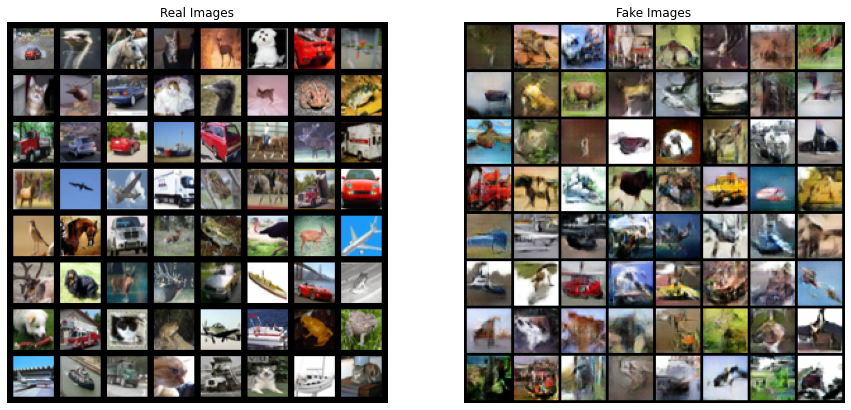

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

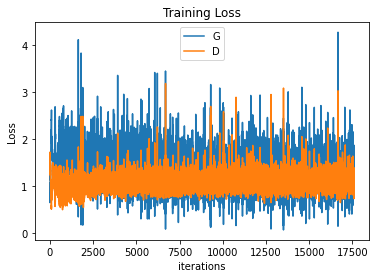

In [18]:
plt.title("Training Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
#plt.plot(fid_scores,label="fid_score")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./loss.jpg")
plt.show()

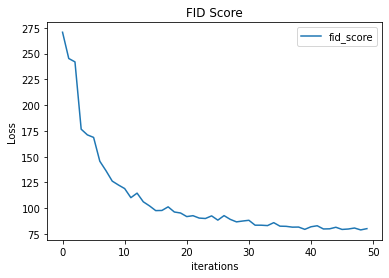

In [19]:
plt.title("FID Score")
#plt.plot(G_losses,label="G")
#plt.plot(D_losses,label="D")
plt.plot(fid_scores,label="fid_score")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("./fid.jpg")
plt.show()